*In the [MutualInclinations](https://github.com/iancze/hierarchical-mutual-inclinations/blob/master/MutualInclinations.ipynb) notebook, we built a hierarchical Bayesian model to infer the distribution of mutual inclinations using a sample of circumbinary disks. At one point, we mentioned that instead of sampling in the azimuthal angle $\phi$, we could actually analytically marginalize it out of our prior. This notebook details the math of the marginalization, setting this up in PyMC3, and sampling it.*


Ok, now that we've defined $\theta$ and $\phi$ in the disk frame and specified how to convert these back to the observer frame, let's get back to the hierarchical model. A mutual inclination prior $p(\theta)$ specifies the angle between the disk and binary unit angular momentum vectors, but not the azimuthal orientation of them ($\phi$). So, given some mutual inclination $\theta$, the prior on the position of the binary unit vector on the unit sphere looks like a ring centered on the disk unit vector. This means that in the frame of the disk, the prior on the binary unit vector location is separable, 

$$
p(\theta, \phi) = p(\theta) p(\phi)
$$
 
where $p(\phi)$ is uniform from $[0, 2\pi]$. 

At any point along the ring $\phi | \theta$ we can use the relationship $i_\star = \cos^{-1} Z$ to calculate $i_\star$. Writing this all out, we have a functional relationship

$$
\cos i_\star = f_\star(\cos i_\mathrm{disk}, \theta, \phi) =  -\sqrt{1 - \cos^2 i_\mathrm{disk}} \sin \theta \sin \phi + \cos i_\mathrm{disk} \cos \theta
$$

Framing this differently, we can say that if we know $i_\mathrm{disk}$, $\theta$, and $\phi$, we essentially have a $\delta$-function prior on $\cos i_\star$

$$
p(\cos i_\star | \cos i_\mathrm{disk}, \theta, \phi) = \delta(\cos i_\star - f_\star(\cos i_\mathrm{disk}, \theta, \phi))
$$

As we mentioned, because we don't have any constraint on $\Delta \Omega$, we don't have any constraint on $\phi$ either (note that $\Delta \Omega \ne \phi$, but these quantites are related through the rotation matrices in a one-to-one manner once $\cos i_\mathrm{disk}$, $\theta$ and $\cos i_\star$ are specified). 



My mother told me never to sample tomorrow what I could analytically marginalize today (or was it never put off until tomorrow what I can do today?). So, we'd like to rearrange the math a little so we can derive a prior on $\cos i_\star$ that has been marginalized over our ignorance on $\phi$.

We'll start by writing the joint distribution 

$$
p(\cos i_\star, \phi | \cos i_\mathrm{disk}, \theta) =  p(\cos i_\star | \cos i_\mathrm{disk}, \theta, \phi) p(\phi)
$$

$$
p(\cos i_\star, \phi | \cos i_\mathrm{disk}, \theta) = \delta(\cos i_\star - f_\star(\cos i_\mathrm{disk}, \theta, \phi))  p(\phi)
$$

To derive the marginal distribution we'll integrate over $\phi$,

$$
p(\cos i_\star | \cos i_\mathrm{disk}, \theta)  = \int_0^{2\pi} p(\cos i_\star, \phi | \cos i_\mathrm{disk}, \theta) \, \mathrm{d}\phi
$$


$$
p(\cos i_\star | \cos i_\mathrm{disk}, \theta)  = \int_0^{2\pi} \delta(\cos i_\star - f_\star(\cos i_\mathrm{disk}, \theta, \phi))  \, p(\phi) \, \mathrm{d}\phi
$$

Let

$$
g(\phi) = \cos i_\star - f_\star(\cos i_\mathrm{disk}, \theta, \phi)
$$

$$
g(\phi) = \cos i_\star + \sqrt{1 - \cos^2 i_\mathrm{disk}} \sin \theta \sin \phi - \cos i_\mathrm{disk} \cos \theta
$$


$$
p(\cos i_\star | \cos i_\mathrm{disk}, \theta)  = \frac{1}{2\pi} \int_0^{2\pi} \delta(g(\phi)) \, \mathrm{d}\phi
$$


To evaluate this integral, we'll use a neat trick of $\delta$ function composition to rewrite the argument into something more friendly to integrate. The $\delta$ function composition rule states

$$
\delta(g(\phi)) = \sum_i \frac{\delta(\phi - \phi_i)}{|g^\prime (\phi_i)|}
$$

where $\phi_i$ are the roots of the equation. This part makes sense if you think about $\delta(g(\phi))$ as having a $\delta$ function pop up everywhere $g(\phi) = 0$ (i.e., the roots of the equation). 

The denominator of this equation, the slope of $g(\phi)$ evaluated at those roots, comes about from the more familiar $\delta$ function scaling relation, 

$$
\delta(\alpha \phi) = \frac{\delta(\phi)}{|\alpha|}
$$

Basically, the $\delta$ functions will be wider in regions where $g(\phi)$ crosses $g = 0$ slowly and narrower in regions where $g(\phi)$ crosses $g = 0$ in a hurry. 

Thinking back to our original diagram (figure forthcoming), where we are tracing a ring on the surface of a sphere, we can make our lives simpler by reconsidering the limits of integration to cover only one side of the circle. Since our rotation convention has $\phi = 0$ starting at the 9 o'clock position, and we want to integrate from top to bottom, this means from $-\pi/2$ to $\pi/2$.

$$
p(\cos i_\star | \cos i_\mathrm{disk}, \theta)  = \frac{1}{2\pi} \int_0^{2\pi} \delta(g(\phi)) \, \mathrm{d}\phi = \frac{1}{\pi} \int_{-\pi/2}^{\pi/2} \delta(g(\phi)) \, \mathrm{d}\phi
$$

The nice part about this change is that there is only one root in this domain, meaning that given $\cos i_\star$, $\cos i_\mathrm{disk}$, and $\theta$, there is exactly one $\phi$ in this range (the other is on the other half of the circle). Solving $g(\phi) = 0$ for the root, we have

$$
\sin \phi_0 = \frac{\cos i_\mathrm{disk} \cos \theta - \cos i_\star}{\sqrt{1 - \cos^2 i_\mathrm{disk}} \sin \theta}
$$

$$
\phi_0 = \sin^{-1} \left [  \frac{\cos i_\mathrm{disk} \cos \theta - \cos i_\star}{\sqrt{1 - \cos^2 i_\mathrm{disk}} \sin \theta} \right ]
$$


The derivative of $g(\phi)$ is

$$
\frac{\mathrm{d} g}{\mathrm{d}\phi} = \sqrt{1 - \cos^2 i_\mathrm{disk}} \sin \theta \cos \phi
$$

Evaluating the derivative at the root, we have

$$
\left | \frac{\mathrm{d} g}{\mathrm{d}\phi} (\phi_i) \right | = \left | \sqrt{1 - \cos^2 i_\mathrm{disk}} \sin \theta \sqrt{1 - \left ( \frac{\cos i_\mathrm{disk} \cos \theta - \cos i_\star}{\sqrt{1 - \cos^2 i_\mathrm{disk}} \sin \theta} \right)^2} \; \right |
$$

Using these relationships, we have rewritten

$$
\frac{1}{\pi} \int_{-\pi/2}^{\pi/2} \delta(g(\phi)) \, \mathrm{d}\phi = \frac{1}{\pi} \left ( \left | \frac{\mathrm{d} g}{\mathrm{d}\phi} (\phi_i) \right | \right )^{-1} \int_{-\pi/2}^{\pi/2} \delta(\phi - \phi_0) \, \mathrm{d}\phi
$$

$$
\frac{1}{\pi} \int_{-\pi/2}^{\pi/2} \delta(g(\phi)) \, \mathrm{d}\phi = \frac{1}{\pi} \left ( \left | \frac{\mathrm{d} g}{\mathrm{d}\phi} (\phi_i) \right | \right )^{-1} 
$$

$$
p(\cos i_\star | \cos i_\mathrm{disk}, \theta) = \frac{1}{\pi} \left | \sqrt{1 - \cos^2 i_\mathrm{disk}} \sin \theta \sqrt{1 - \left ( \frac{\cos i_\mathrm{disk} \cos \theta - \cos i_\star}{\sqrt{1 - \cos^2 i_\mathrm{disk}} \sin \theta} \right)^2} \; \right |^{-1} 
$$

$$
p(\cos i_\star | \cos i_\mathrm{disk}, \theta) = \frac{1}{\pi} \left | \sin i_\mathrm{disk} \sin \theta \sqrt{1 - \left ( \frac{\cos i_\mathrm{disk} \cos \theta - \cos i_\star}{\sin i_\mathrm{disk} \sin \theta} \right)^2} \; \right |^{-1} 
$$


This doesn't look particularly pretty, but we can verify that we have this prior correct by generating random samples from $p(\phi | \cos i_\mathrm{disk}, \theta)$, calculating $\cos i_\star$ from them and then plotting the $p(\cos i_\star | \cos i_\mathrm{disk}, \theta)$ histogram, i.e., the marginal prior.

## $u$-substitution

This can also be calculated (slightly more easily) with $u$ substitution. We need to calculate the integral

$$
\frac{1}{\pi} \int_{-\pi/2}^{\pi/2} \delta(g(\phi))\, \mathrm{d}\phi
$$

Let $u = \sin \theta$, then $\mathrm{d}u = \cos \phi \, \mathrm{d} \phi$. So we have

$$
\mathrm{d}\phi = \frac{\mathrm{d}u}{\cos \phi} = \frac{\mathrm{d}u}{\sqrt{1 - u^2}}
$$

$$
g(u) = \cos i_\star + \sin i_\mathrm{disk} \sin \theta \, u - \cos i_\mathrm{disk} \cos \theta
$$

$$
g^\prime(u) = \sin i_\mathrm{disk} \sin \theta
$$

Solving for the $g(u) = 0$ root,

$$
u_0 = \frac{\cos i_\mathrm{disk} \cos \theta - \cos i_\star}{\sin i_\mathrm{disk} \sin \theta}
$$

and using the composition rule,

$$
\delta(g(u)) = \frac{\delta(u - u_0)}{|\sin i_\mathrm{disk} \sin \theta | }
$$

the integral becomes

$$
\frac{1}{\pi} \int_{-\pi/2}^{\pi/2} \delta(g(\phi))\, \mathrm{d}\phi = \frac{1}{\pi} \frac{1}{|\sin i_\mathrm{disk} \sin \theta |} \int_{-1}^1 \frac{\delta(u - u_0)}{\sqrt{1 - u^2}}\, \mathrm{d}u
$$

Now this is a $\delta$ function integral that is a bit more easier to comprehend. It just picks up the value of the function $1 / \sqrt{1 - u^2}$ where $u = u_0$, so the final solution is 

$$
\frac{1}{\pi} \frac{1}{|\sin i_\mathrm{disk} \sin \theta|} \frac{1}{\sqrt{1 - u_0^2}}
$$

which is the same thing as before.

Now that we've specified this prior, we can write the full posterior with the rest of the terms.

$$
p_k(\cos i_\mathrm{disk}, \cos i_\star| \cos \hat{i}_\mathrm{disk}, \cos \hat{i}_\star, \alpha, \beta) = {\cal N}(\cos \hat{i}_\mathrm{disk}, \cos \hat{i}_\star | \cos i_\mathrm{disk}, \cos i_\star, \boldsymbol{\Sigma}) p(\cos i_\star | \cos i_\mathrm{disk}, \theta) p(\cos i_\mathrm{disk}) p(\theta |, \alpha, \beta)
$$

This posterior looks a little bit different than before. For this single disk $k$, it looks quite simple, since it only has two parameters, $\cos i_\mathrm{disk}$ and $\cos i_\star$. Looking more closely, we see that this whole posterior is conditional on the prior for the mutual inclinations, which we've specified with a $\beta$ distribution $p_\beta$, parameterized by $\alpha$ and $\beta$. With the full sample of disks, we will seek to infer $\alpha$ and $\beta$ as well. This is the hierarchical nature of the problem.


Just trying to experiment implementing the marginal prior. It has the form

$$
p(\cos i_\star | \cos i_\mathrm{disk}, \theta) = \frac{1}{\pi} \left | \sin i_\mathrm{disk} \sin \theta \sqrt{1 - \left ( \frac{\cos i_\mathrm{disk} \cos \theta - \cos i_\star}{\sin i_\mathrm{disk} \sin \theta} \right)^2} \; \right |^{-1} 
$$

Since we know that $i_\mathrm{disk}$ and $\theta$ will always be in the range $[0, \pi]$, the absolute value bars are not necessary.


$$
p(\cos i_\star | \cos i_\mathrm{disk}, \theta) = \frac{1}{\pi} \left ( \sin i_\mathrm{disk} \sin \theta \sqrt{1 - \left ( \frac{\cos i_\mathrm{disk} \cos \theta - \cos i_\star}{\sin i_\mathrm{disk} \sin \theta} \right)^2} \; \right )^{-1} 
$$

and (dropping constants)

$$
\ln p(\cos i_\star | \cos i_\mathrm{disk}, \theta) = - \ln \sin i_\mathrm{disk} - \ln \sin(\theta) - \frac{1}{2} \ln \left [ 1 - \left ( \frac{\cos i_\mathrm{disk} \cos \theta - \cos i_\star}{\sin i_\mathrm{disk} \sin \theta} \right )^2\right]
$$


We can calculate the domain of this distribution by realizing 

$$
1 - \left ( \frac{\cos i_\mathrm{disk} \cos \theta - \cos i_\star}{\sin i_\mathrm{disk} \sin \theta} \right )^2 > 0
$$

or 

$$
-1 < \left (\frac{\cos i_\mathrm{disk} \cos \theta - \cos i_\star}{\sin i_\mathrm{disk} \sin \theta} \right ) < 1
$$

or

$$
\cos i_\mathrm{disk} - \sin i_\mathrm{disk} \sin \theta < \cos i_\star < \sin i_\mathrm{disk} \sin \theta + \cos i_\mathrm{disk} \cos \theta
$$

In [1]:
# code here
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
import matplotlib.pyplot as plt

import numpy as np
import theano.tensor as tt
import pymc3 as pm

deg = np.pi/180.0

In [29]:
def get_limits(cos_i_disk, theta):
    '''
    theta in radians
    '''
    sin_i_disk = np.sqrt(1 - cos_i_disk**2)

    low = cos_i_disk - sin_i_disk * np.sin(theta)
    high = sin_i_disk * np.sin(theta) + cos_i_disk * np.cos(theta)
    
    return low, high

In [47]:
# choose a cos i_disk, and theta value 
cos_i_disk = np.cos(40.0 * deg)
theta = 5.0 * deg

def lnp(cos_i_star): #, cos_i_disk, theta):
    sin_i_disk = tt.sqrt(1 - cos_i_disk**2)

    # limits on where function is defined
    low = cos_i_disk - sin_i_disk * np.sin(theta)
    high = sin_i_disk * np.sin(theta) + cos_i_disk * np.cos(theta)
    
    # specify the bounds via returning -inf
    
    return tt.switch(tt.and_(tt.lt(low, cos_i_star), tt.lt(cos_i_star, high)), -tt.log(sin_i_disk) - tt.log(tt.sin(theta)) - \
    0.5 * tt.log(1 - ((cos_i_disk * tt.cos(theta) - cos_i_star)/(sin_i_disk * tt.sin(theta)))**2), -1.0)

In [ ]:
import theano.tensor as T

with pymc.Model() as model:
    alpha = pymc.Uniform('intercept', -100, 100)
    # Create custom densities
    beta = pymc.DensityDist('slope', lambda value: -1.5 * T.log(1 + value**2), testval=0)
    sigma = pymc.DensityDist('sigma', lambda value: -T.log(T.abs_(value)), testval=1)
    # Create likelihood
    like = pymc.Normal('y_est', mu=alpha + beta * xdata, sd=sigma, observed=ydata)
    
    start = pymc.find_MAP()
    step = pymc.NUTS(scaling=start) # Instantiate sampler
    trace = pymc.sample(10000, step, start=start, progressbar=False) 

In [48]:
# for now these are just fixed 
cos_i_disk = np.cos(40.0 * deg)
theta = 5.0 * deg

# low, high = get_limits(cos_i_disk, theta)

with pm.Model() as model:

    # Now, we will use cos_i_disk and theta to calculate the prior on cos_i_star
#     sin_i_disk = tt.sqrt(1.0 - cos_i_disk**2)

    # see https://discourse.pymc.io/t/first-attempt-at-a-hierarchical-model-with-custom-likelihood/1928
    # for conditional prior help
    # the domain of this dist is between 
#     def lnp(cos_i_star): 
#         return -tt.log(sin_i_disk) - tt.log(tt.sin(theta)) - \
#         0.5 * tt.log(1 - ((cos_i_disk * tt.cos(theta) - cos_i_star)/(sin_i_disk * tt.sin(theta)))**2)
    
    # the disk inclination is probably a good place to start
    cos_i_star = pm.DensityDist("cos_i_star", lnp, testval=cos_i_disk)
    
    p1 = tt.printing.Print('cos_i_star')(cos_i_star)

cos_i_star __str__ = 0.7660444431189781


In [51]:
with model:
#     trace = pm.sample(5)
    trace = pm.sample(3, tune=100, chains=1, progressbar=False) 

Only 3 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [cos_i_star]


ValueError: Mass matrix contains non-finite values on the diagonal. 
The derivative of RV `cos_i_star`.ravel()[0] is non-finite.

0.710021811567756 0.8191520442889919


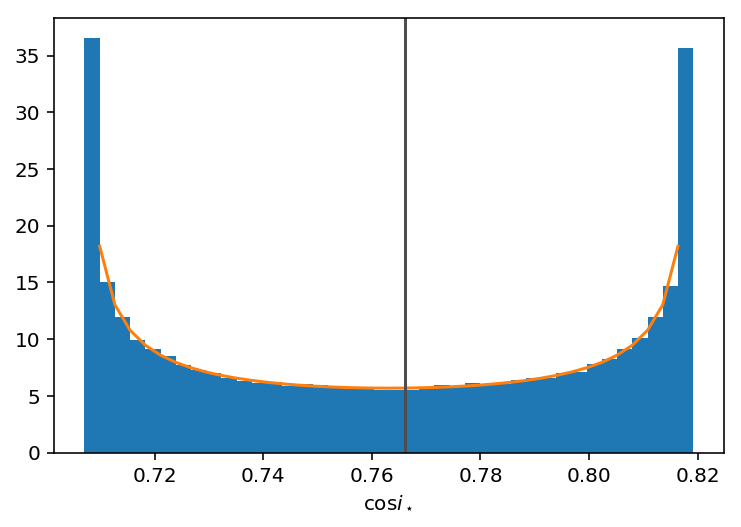

In [27]:
def p_marg(cos_i_star, cos_i_disk, theta):
    '''
    Assumes radians for angles.
    '''
    
    sin_i_disk = np.sqrt(1 - cos_i_disk**2)
    
    # the limits of this function
    low = cos_i_disk - sin_i_disk * np.sin(theta)
    high = sin_i_disk * np.sin(theta) + cos_i_disk * np.cos(theta)
    
    print(low, high)
    
    return 1 / (np.pi * np.sqrt(1 - cos_i_disk**2) * np.sin(theta) * \
                np.sqrt(1 - ((cos_i_disk * np.cos(theta) - cos_i_star) / \
               (np.sqrt(1 - cos_i_disk**2) * np.sin(theta)))**2)) 

# choose a cos i_disk, and theta value 
cos_i_disk = np.cos(40.0 * deg)
theta = 5.0 * deg

phis = np.random.uniform(0, 2 * np.pi, size=100000)

cos_i_stars = -np.sqrt(1 - cos_i_disk**2) * np.sin(theta) * np.sin(phis) + cos_i_disk * np.cos(theta)

res = plt.hist(cos_i_stars, bins=40, density=True)
heights, bins, patches = res
plt.plot(bins[1:-1], p_marg(bins[1:-1], cos_i_disk, theta)) # it will blow up at the edges
plt.axvline(cos_i_disk, color="0.3")
plt.xlabel(r"$\cos i_\star$");


Notes on this are here: https://docs.pymc.io/Probability_Distributions.html

In [ ]:
def logp(failure, value):
    return (failure * log(λ) - λ * value).sum()

exp_surv = pm.DensityDist('exp_surv', logp, observed={'failure':failure, 'value':t})